# How Can O-List Improve Its Profit?

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from IPython.display import Markdown as md

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the opposite  
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

## Data Preparation

In [3]:
from olist.seller_updated import Seller
seller = Seller()

In [4]:
sellers = seller.get_training_data()

In [5]:
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,-83.201


### Revenues

In [6]:
revenues_sales = sellers.sales.sum() * 0.1
revenues_subscription = sellers.months_on_olist.sum() * 80
revenues_total = sellers.revenues.sum()

print(
    f'''
Revenues: {revenues_total:.2f} BRL
- Sales: {revenues_sales:.2f} BRL
- Subscriptions: {revenues_subscription:.2f} BRL
''')


Revenues: 2785818.44 BRL
- Sales: 1355578.44 BRL
- Subscriptions: 1430240.00 BRL



## Costs

In [7]:
costs_reviews = sellers.cost_of_reviews.sum()
costs_it = 500_000
costs_total = costs_reviews + costs_it

print(
    f'''
Costs: {costs_total:.2f} BRL
- Reviews: {costs_reviews:.2f} BRL
- IT: {costs_it:.2f} BRL
''')


Costs: 2118210.00 BRL
- Reviews: 1618210.00 BRL
- IT: 500000.00 BRL



## Profits

In [8]:
# Gross Profit, before IT costs
profits_gross = sellers.profits.sum()
profits_gross

1167608.4440000001

In [9]:
# Gross Profit, after IT costs
profits_net = profits_gross - costs_it
profits_net

667608.4440000001

In [10]:
init_notebook_mode(connected=True)

fig = go.Figure(go.Waterfall(
    orientation = "v",
    measure = ["relative", "relative", "total", "relative", "total", "relative", "total"],
    x = ["Monthly subcriptions", "Sales fees", "Total Revenues", "Reviews costs", "Gross Profit", "It costs", "Net Profit"],
    textposition = "outside",
#    text = ["", "+80", "", "-40", "-20", "Total"],
    y = [revenues_subscription, revenues_sales, 0, -costs_reviews, 0,-costs_it, 0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = {'text': "Olist Profit & Loss (BRL)",
                 'yanchor': 'top',
                 'xanchor': 'left',
                 'xref': 'paper',
                 'font': {'size': 36}},
        showlegend = False
)

fig.show()

# Under Performing Sellers

In [11]:
# Total number of sellers
n_sellers = sellers.shape[0]


# Number of sellers with negative profits
n_negative = sellers.query('profits <= 0').shape[0]

# % of sellers with negative profits
pct_negative = n_negative / n_sellers

# Mean and median of sellers'profits
mean, med = sellers.profits.mean(), sellers.profits.median()

# .25 quantile
q25 = sellers.profits.quantile(q=.25)

# Min, Max of sellers'profits
min_, max_ = sellers.profits.min(), sellers.profits.max()

In [12]:
n_sellers, n_negative, pct_negative, mean, med, q25, min_, max_

(2967,
 376,
 0.1267273340074149,
 393.53166295921693,
 254.37,
 20.98,
 -21519.517,
 18067.605)

There are **2967** sellers on Olist  

Insights on the **profits** they generate **for Olist**:

* **376 (12.6%)** of them generate a **negative profit**  

* Profits across sellers from **-21k** to **18k** BRL  

* The average profit per seller is **393** BRL  

* **50%** of sellers generate at least a profit of **254** BRL  

* **25%** of sellers generate a profit inferior to **30** BRL

In [13]:
STYLES = {'title': {'weight':'heavy', 'name':'Liberation Serif', 'size':16,},
          'labels': {'weight': 'heavy', 'name': 'Liberation Serif', 'size': 14}}

findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.


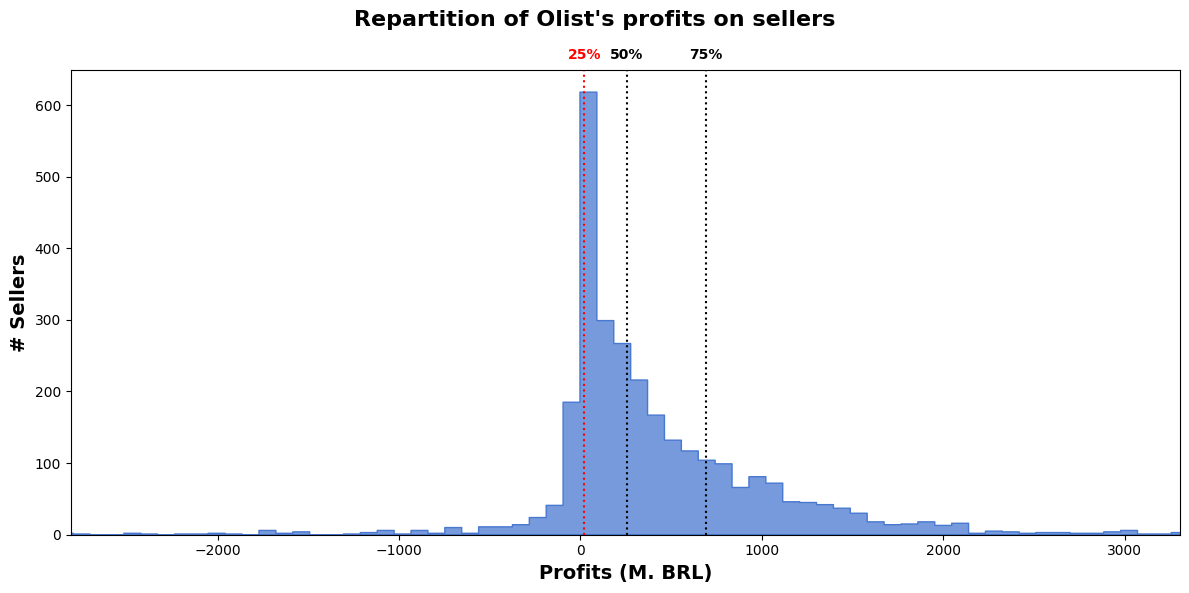

In [14]:
sns.set_palette('muted')

fig, ax = plt.subplots(figsize=(12, 6))

plt.suptitle(t="Repartition of Olist's profits on sellers",
             **STYLES['title'])

sns.histplot(sellers.profits,
             stat='count',
             element='step',
             ax=ax)

quantiles = sellers.profits.quantile(q=[.01, .25, .5, .75, .99])

ax.set_xlim(quantiles.iloc[0], quantiles.iloc[-1])
ax.set_xlabel(xlabel='Profits (M. BRL)',
              fontdict=STYLES['labels'])
ax.set_ylabel(ylabel='# Sellers',
              fontdict=STYLES['labels'])

for p, q in quantiles.iloc[1:-1].items():
    c_ = 'black'
    if p == .25:
        c_ = 'red'
    ax.axvline(x=q,
               color=c_,
               ls=':')
    ax.text(x=q,
            y=ax.get_yticks()[-1] - 30,
            s=f'{p:.0%}',
            color=c_,
            ha='center',
            va='center',
            weight='bold')

fig.tight_layout();

For reference, we will consider the **742** sellers that yielded a profit inferior to **30** BRL as **under-performers**

# Exploratory Analysis

Let's see the financial impact of **removing sellers**, starting from the **less profitable one**

We **rank** the sellers by **increasing profits**, and estimate the **costs** and **revenues** after removing them from Olist over the past 16 months

## Data Preparation

In [17]:
sorted_sellers = sellers.sort_values(by='profits') \
                    [['months_on_olist',
                      'sales',
                      'profits',
                      'revenues',
                      'quantity',
                      'cost_of_reviews']] \
                    .reset_index()

sorted_sellers.head()

,index,months_on_olist,sales,profits,revenues,quantity,cost_of_reviews
0,769,18.0,123304.83,-21519.517,13770.483,2033,35290
1,2358,20.0,200472.92,-17752.708,21647.292,1987,39400
2,1357,19.0,104288.42,-17581.158,11948.842,1775,29530
3,945,12.0,37177.52,-15542.248,4677.752,1203,20220
4,315,10.0,17535.69,-12886.431,2553.569,1018,15440


In [18]:
gross_profits_per_seller_removed = profits_gross - np.cumsum(sorted_sellers.profits[:-1])
review_costs_per_seller_removed = costs_reviews - np.cumsum(sorted_sellers.cost_of_reviews[:-1])
revenues_per_seller_removed = revenues_total - np.cumsum(sorted_sellers.revenues[:-1])

## Revenue

In [19]:
fees_per_seller_removed = revenues_sales - np.cumsum(sorted_sellers.sales[:-1] * .1)
suscriptions_per_seller_removed = revenues_subscription - np.cumsum(sorted_sellers.months_on_olist[:-1] * 80)

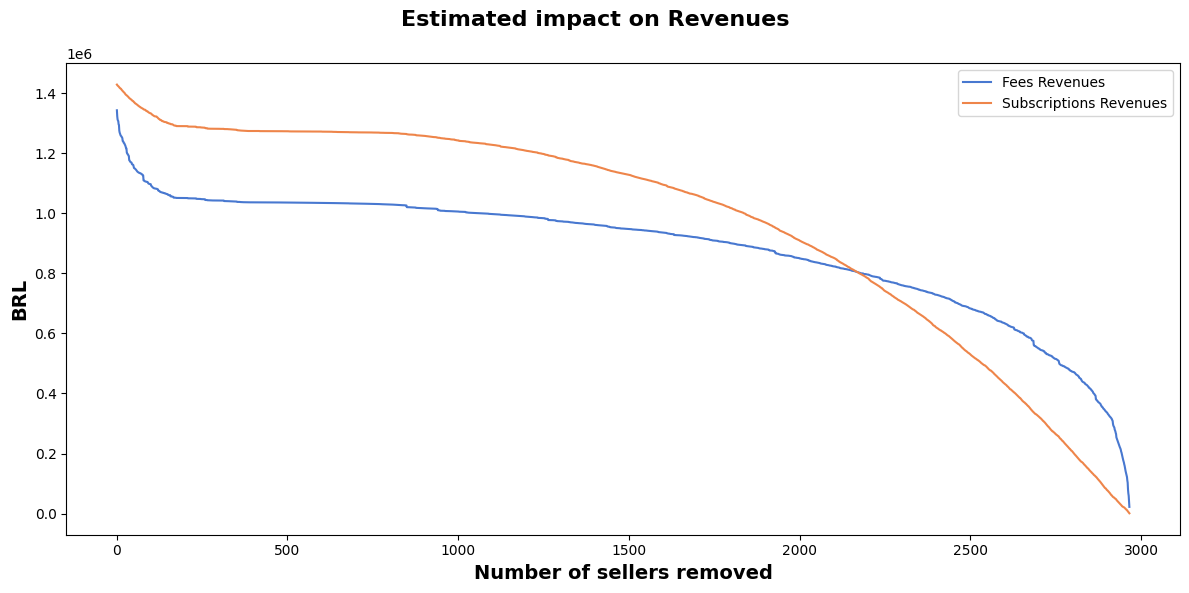

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(1, n_sellers, 1)

plt.suptitle(t="Estimated impact on Revenues",
             **STYLES['title'])

profit_line = sns.lineplot(x=x,
                           y=fees_per_seller_removed,
                           label='Fees Revenues',
                           ax=ax)

revenue_line = sns.lineplot(x=x,
                            y=suscriptions_per_seller_removed,
                            label='Subscriptions Revenues',
                            ax=ax)

ax.set_xlabel('Number of sellers removed',
                  fontdict=STYLES['labels'])
ax.set_ylabel('BRL',
                  fontdict=STYLES['labels'])

ax.tick_params(axis='y')

ax.legend()

fig.tight_layout()

## IT Costs scaling parameters $\alpha$ and $\beta$

We know that the total IT Costs scale with both the number of sellers (`n_sellers`) and the amount of products they sold (`n_products`)  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  

- $\alpha = 3157.27$
- $\beta = 978.23$

In [22]:
alpha, beta = 3157.27, 978.23
n_sellers = sellers.shape[0]
n_products = sellers.quantity.sum()

In [23]:
def compute_costs_of_it(n_sellers, n_products):
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_products)

In [24]:
new_n_sellers = n_sellers - np.arange(1, n_sellers, 1)
new_n_products = n_products - np.cumsum(sorted_sellers.quantity[:-1])

it_costs_per_seller_removed = compute_costs_of_it(new_n_sellers, new_n_products)
review_costs_per_seller_removed = sellers.cost_of_reviews.sum() - np.cumsum(sorted_sellers.cost_of_reviews[:-1])

costs_per_seller_removed = it_costs_per_seller_removed + review_costs_per_seller_removed

## Costs

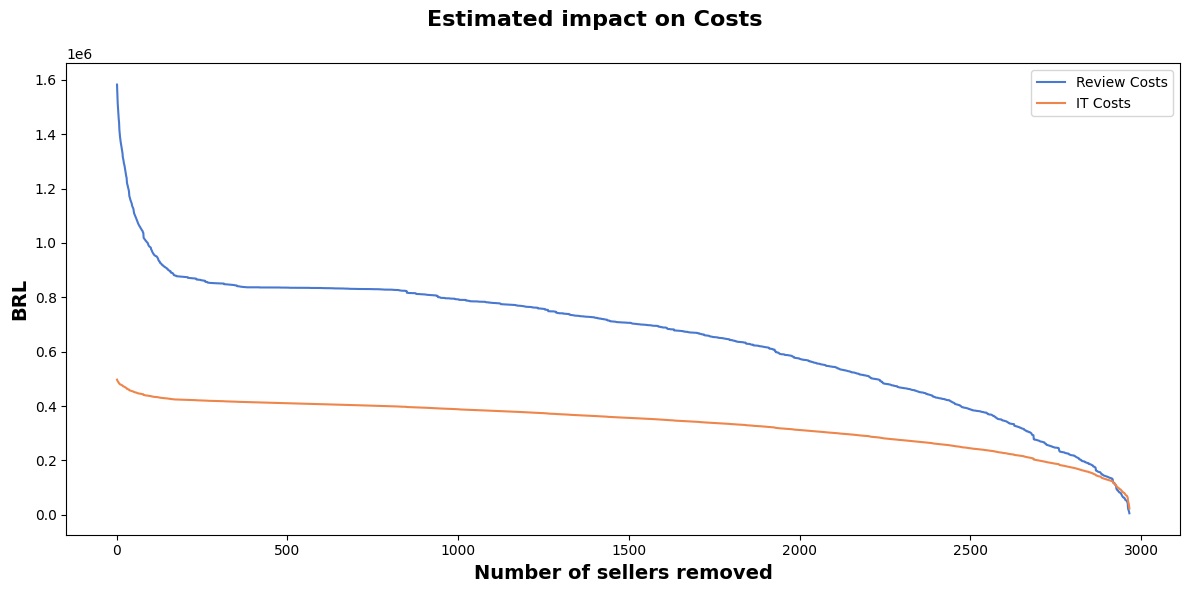

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(1, n_sellers, 1)

plt.suptitle(t="Estimated impact on Costs",
             **STYLES['title'])

profit_line = sns.lineplot(x=x,
                           y=review_costs_per_seller_removed,
                           label='Review Costs',
                           ax=ax)

revenue_line = sns.lineplot(x=x,
                            y=it_costs_per_seller_removed,
                            label='IT Costs',
                            ax=ax)

ax.set_xlabel('Number of sellers removed',
                  fontdict=STYLES['labels'])
ax.set_ylabel('BRL',
                  fontdict=STYLES['labels'])

ax.tick_params(axis='y')

ax.legend()

fig.tight_layout()

Removing the less profitable sellers nets a great decrease of the estimated costs of bad reviews

IT Costs seem less relevant to this analysis

In [27]:
# Compute final metrics (profits and margin, for each scenario!)
profits_per_seller_removed = gross_profits_per_seller_removed - it_costs_per_seller_removed
margin_per_seller_removed = profits_per_seller_removed / revenues_per_seller_removed

## How many under-performing sellers to remove?

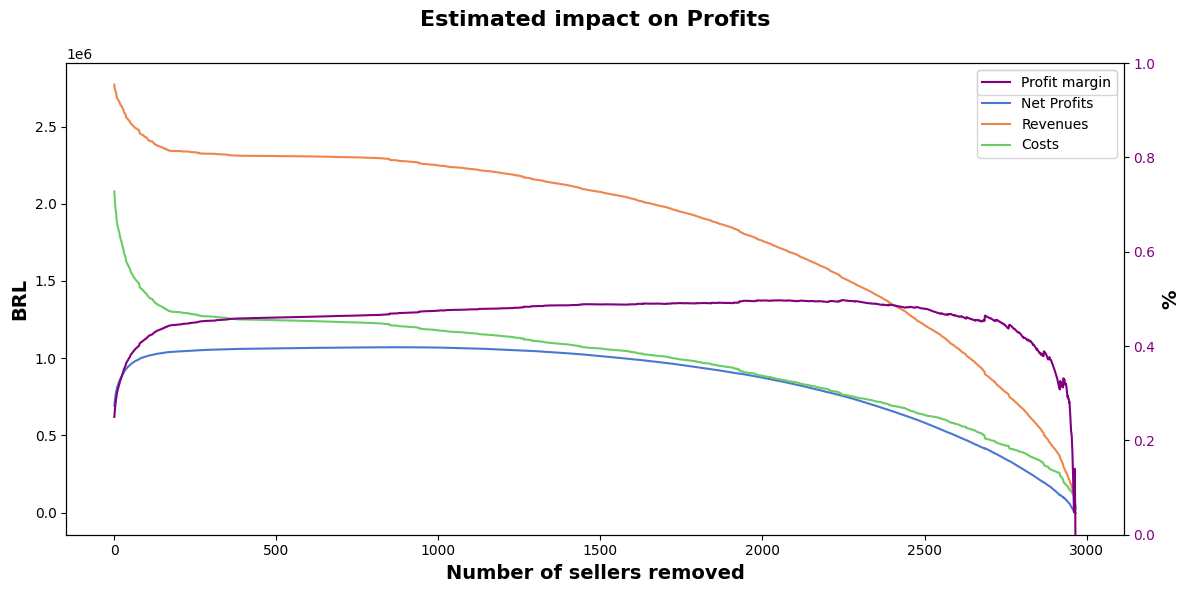

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))

axs = [ax, ax.twinx()]

x = np.arange(1, n_sellers, 1)

plt.suptitle(t="Estimated impact on Profits",
             **STYLES['title'])

profit_line = sns.lineplot(x=x,
                           y=profits_per_seller_removed,
                           label='Net Profits',
                           ax=axs[0])

revenue_line = sns.lineplot(x=x,
                            y=revenues_per_seller_removed,
                            label='Revenues',
                            ax=axs[0])

costs_line = sns.lineplot(x=x,
                          y=costs_per_seller_removed,
                          label='Costs',
                          ax=axs[0])

axs[0].set_xlabel('Number of sellers removed',
                  fontdict=STYLES['labels'])
axs[0].set_ylabel('BRL',
                  fontdict=STYLES['labels'])

axs[0].tick_params(axis='y')

margin_line = sns.lineplot(x=x,
                           y=margin_per_seller_removed,
                           label='Profit margin',
                           color='purple',
                          ax=axs[1])

axs[1].set_ylabel('%',
                  fontdict=STYLES['labels'])
axs[1].tick_params(axis='y',
                   labelcolor='purple')
axs[1].set(ylim=[0, 1])

lines = [axs[1].lines[0], *axs[0].lines]
labels = [line.get_label() for line in lines]
axs[0].legend(lines, labels)

fig.tight_layout()

In [29]:
# Find optimal number of sellers to remove
profits_per_seller_removed.argmax(), profits_per_seller_removed.argmax() / n_sellers, \
margin_per_seller_removed.argmax(), margin_per_seller_removed.argmax() / n_sellers

(854, 0.2878328277721604, 2244, 0.756319514661274)

## 📊 Decision thresholds
* Optimizing for **profits** requires removing **854 (29%)** sellers
* Optimizing for the **profit margin** requires removing **2244 (76%)** sellers  